In [1]:
using Distributions, LinearAlgebra, Statistics, Plots, StatsPlots, Random, Optim;

In [2]:
pyplot();

## Introduction

<p>ㅤㅤㅤㅤIn our class, we have explored different methods for inverse problems. As the professor told us that inverse problems were the same as parameter estimations in the first meeting, we have tried to find parameter values of a given model. In real life, however, it is often likely that there is no model given, and all you have is your input and output data. In addition, your goal might be just estimating output values given input values rather than finding an analytical function. In these cases, nonparametric regression could be useful because you do not assume a certain parametric form for a model. 
	This paper explore three nonparametric regression methods: k-nearest-neighbors (hereinafter called “knn”),  the Nadaraya-Watson kernel regression (hereinafter called “kernel smoothing”or "the kernel regression"), and local regressions.  </p>

#### 1. Knn Regression
ㅤㅤㅤㅤKnn regression is defined as $$\hat f(x) = \frac{1}{k} \sum_{i \in N_k(x)}y_i$$ This means that the estimated output value of a given input $x$ is the average $y$ values of the $k$ points closest to $x$, where $k>0$ is the number of closest data points that you consider. For instance, if you have pairs of input-output data ${(x,y)=(1,3), (2,4), (3,5)}$, then $\hat f(1.5)$ with $k=2$ would be $3.5$ because the two $x$ points closest to $1.5$ are $1$ and $2$, and the average of y values corresponding with the $x$ points is $(3+4)/2 = 3.5$.


#### 2. Kernel Smoothing
ㅤㅤㅤㅤFor simplicity, we assume $d=1$, which means input data is a single value. A kernel function $K: \mathbb{R} \rightarrow \mathbb{R}$ used in kernel smoothing has the following properties: $\int K(x)dx = 1, \int xK(x)dx=0, \,\text{and}\, 0 < \int x^2K(x)dx < \infty$. The most common kernel function is the Gaussican kernel, $K(x) = \frac{1}{\sqrt{2\pi}}exp(-x^2/2)$. Then, with bandwidth parameter $h>0$, the kernel regression is defined as $$\hat f(x) = \frac{\sum_{i=1}^n K(\frac{x_i-x}{h})y_i}{\sum_{i=1}^n K(\frac{x_i-x}{h})}$$ 

This means the estimated output value is a weighted average of output values around $x$. To understand it easily, I want to think about an example of an unweighted average first. Assume we roll a die ten times and calculate the average value facing up. What do we do? We would count the frequency of each value, multiply each frequency by each value, add them up, and divide the sum by the total frequency that is $10$ in this case. We could think of the kernel regression in the same way. That is, $K((x_i-x)/h)$ could be thought as “frequency”, and $y_i$ could be thought as a value. If $K$ is the Gaussican kernel, then $K((x_i-x)/h)$ returns a value indicating how close to $x x_i$ is. For example, if $x_i = x$, then $K$ would return the largest value, $K(0)$, than any other $K((x_i-x)/h)$ since $0$ is the mode of the standard normal distribution. On the other hand, if $x_i << x$ or $x_i >>x$, then the absolute value of $(x_i-x)/h$ would become too large, and K((xi-x)/h) would become almost $0$, which means the kernel regression would not consider information of that point, $(x_i,y_i)$, since it is too far from $x$. Finally, the denominator becomes the sum of “frequencies", and we could think of the kernel regression as a weighted average around $x$. The role of bandwidth $h$ is that it changes the weight for the points around $x$. For example, if $h$ is small, the absolute value of $(x_i-x)/h$ would become large, which would make the weight, $K((x_i-x)/h)$, small. Therefore, the kernel function put more weight on the fewer points closer to $x$ and less weight on the more points far from $x$. On the other hand, if $h$ is large, $K((x_i-x)/h)$ would become large. Therefore, it would put more weight on more points that are not closer to $x$. 


#### 3. Local Regressions
ㅤㅤㅤㅤLocal regression is a slight extention of the kernel regression. Another way of interpreting the kernel regression would be at each input $x$, it employs the estimate $\hat f(x) = \hat \theta$, where $\hat \theta$ is the minimizer of $$\sum_{i=1}^n K(\frac{x-x_i}{h})(y_i-\theta)^2$$

Now, we can think of the local estimate $\hat f(x)=\hat \alpha+\hat \beta x$, where $\hat \alpha, \hat \beta$ minimize $$\sum_{i=1}^nK(\frac{x-x_i}{h})(y_i-\alpha-\beta x_i)^2$$

This is called local linear regression, and we can extend local linear regression to local polynomial regression by fitting $\hat f(x)=\hat \beta_0 + \sum_{j=1}^p\hat \beta_jx^j$, where $\hat \beta_0, ...,\hat \beta_p$ minimize $$\sum_{i=1}^nK(\frac{x-x_i}{h})(y_i-\beta_0-\sum_{j=1}^p\beta_jx_i^j)^2$$

As you can see, the minimizers would be determined by weighted least square errors. That is, higher priorities would be given to the data points close to a point $x$ so it would not care about errors between $x$ and the data point far from $x$. This is why it is called local regressions. The role of bandwidth $h$ for local regressions is the same as the role for the kernel regression. It will control how much weight to be put on the data points around $x$. 

## Method

ㅤㅤㅤㅤI am going to simulate the three methods I have introduced above to observe which one and what parameter can reproduce a model curve the most precisely. To make this simulation easy to observe, I made some assumptions.
* $d=1$ is assumed for all of the three methods.
* The Gaussican kernel will be used for the kernel regression and local regression.
* Only local linear regression will be simulated for local regression.
* The values of $k$ to be used for Knn regression will be $1, 5, 10, 20, \,\text{and}\, 35$.
* The values of $h$ to be used for the kernel regression and local linear regression will be $0.1, 0.5, 1, 2.5,\,\text{and}\, 5$.
* The model to be used will be non-linear function, $f(x)=\frac{3x^3-x^2+3x}{x+10}+\epsilon$, where $\epsilon \sim Normal(0,10)$.
* The input data, $x_i$, is ramdomly sampled from a uniform distribution where $a=-5,b=5$. 
* The number of data points will be $100$.


In [3]:
#define the model
model(x) = (3*x^3-x^2+3*x)/(x+10);

In [4]:
#generate 100 data points 
Random.seed!(10)
N = 100
xdata = rand(Uniform(-5,5),N)
ydata = model.(xdata) .+ rand(Normal(0,10),N);

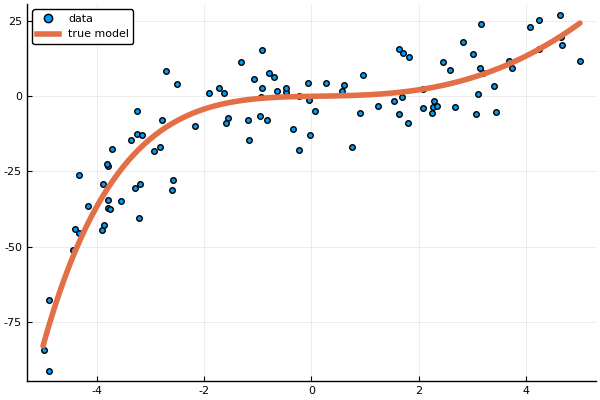

In [5]:
#plot the model curve and data points
xvec = -5:0.1:5
scatter(xdata,ydata, label="data")
plot!(xvec, model.(xvec), label="true model", linewidth=4)

In [6]:
#define knn regression
function knn_reg(x; xdata=xdata,ydata=ydata,k=1, N=N)
    sq = (x' .- xdata).^2
    norm = [sum(sq[i,:]) for i=1:size(sq)[1]]
    
    idx = sortperm(norm)[1:k]
    return sum(ydata[idx])/k, norm[idx[k]]
    end;

In [7]:
#define the kernel function and the kernel regression
n_pdf(x) = pdf(Normal(),x)
function kernel_reg(x; k=n_pdf,h=1)
    
    ary = (x .- xdata)/h
    num = sum(k.(ary) .* ydata)
    denom = sum(k.(ary))
    return num/denom
end;

In [8]:
#define the linear model and local regression
f(x,b1,b2) = b1 + b2*x
function local_regression(f; order=1, h=1, k=n_pdf, xvec=xvec, xdata=xdata, ydata=ydata)
    betas = zeros(length(xvec),order+1)
    for i=1:length(xvec)
        g(b) = sum(k.((xvec[i].-xdata)/h) .* (ydata .- f.(xdata, b[1],b[2])).^2)
        betas[i,:] = optimize(g,[1.0,1.0]).minimizer 
    end
    return betas
end;

In [9]:
#a function to plot knn regressions 
function plot_knn()
    scatter(xdata,ydata, label="data")
    plot!(xvec, model.(xvec), label="true model", linewidth=4, alpha=0.5)
    K = [1,5,10,20,35]
    for j=1:length(K)
        ary = zeros(length(xvec))
        far1 = zeros(length(xvec))
        for i =1:length(xvec)
            ary[i],far1[i] = knn_reg(xvec[i], k=K[j])
        end
        plot!(xvec, ary, label=string("knn regression with k=",K[j]), linewidth=1, alpha=1)
    end
    plot!()
end;

In [10]:
#a function to plot the kernel regressions
function plot_kernel_reg()
    scatter(xdata,ydata, label="data")
    plot!(xvec, model.(xvec), label="true model", linewidth=4, alpha=0.5)
    h = [0.1,0.5,1,2.5,5]
    for j=1:length(h)
        plot!(xvec, kernel_reg.(xvec, h=h[j]), label=string("the kernel regression with h=",h[j]), linewidth=2, alpha=1)
    end
    plot!()
    end;

In [11]:
#a funtion to plot local linear regressions
function plot_local_regression()
    scatter(xdata,ydata, label="data")
    plot!(xvec, model.(xvec), label="true model", linewidth=4, alpha=0.5)
    h = [0.1,0.5,1,2.5,5]
    for j=1:length(h)
        lo = ((local_regression(f,h=h[j]).*[ones(length(xvec)) xvec])[:,1] .+ (
    local_regression(f,h=h[j]).*[ones(length(xvec)) xvec])[:,2])
        plot!(xvec, lo, label=string("local linear regression with h=",h[j]), linewidth=2, alpha=1)
    end
    plot!()
end;

## Results

The result of each method is shown below.

#### 1. Knn Regression

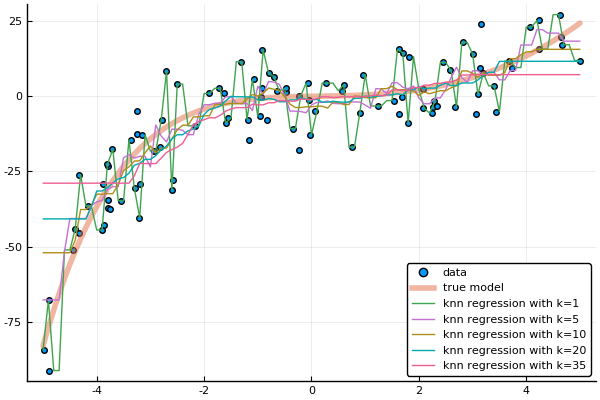

In [12]:
plot_knn()

#### 2. Kernel Smoothing

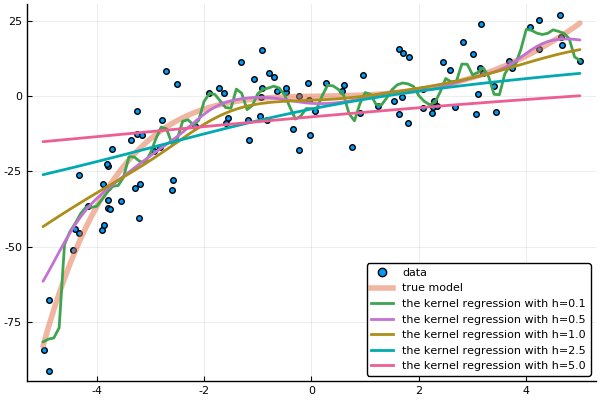

In [13]:
plot_kernel_reg()

#### 3. Local Linear Regression

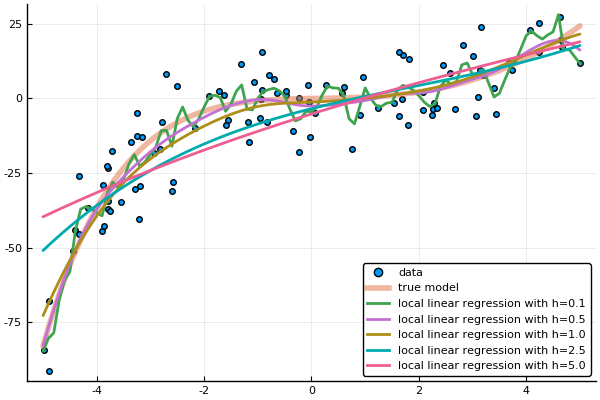

In [14]:
plot_local_regression()

## Conclusion
ㅤㅤㅤㅤFirst, for knn regressions, we can see that they have two major flaws. When $k$ is small, such as $k=1$ and $k=5$, the curves wiggled a lot and did not fit the true model since they only cared about a small number of the data point around $x$, and $\hat f(x)$ changed too frequently. When $k$ is larger, such as $k=10$, $k=20$, and $k=35$, the curves were less jagged and performed well in a range $(-3,3)$, but they did not fit outside the range. This happened because there were not many points to consider at the edges, and more data points from the middle were considered when $\hat f(x)$ was evaluated around the edges. However, if we had to pick the best $k$, it would be $k=5$ since the curve was balanced more nicely than the others in terms of the two points I have discussed. 

ㅤㅤㅤㅤFor the kernel regressions, almost the same things as knn regressions happened. When $h$ is small, the curve wiggled since more weight was put on a few data points around $x$, and less or no weight was put on most of the data points. Therefore, $\hat f(x)$ changed too frequently. On the other hand, as $h$ got larger, the curve got much smoother than knn regressions because $\hat f(x)$ was a weight average. However, the curves with bigger $h$ did not perform well around the edges for the same reason as in the case of knn regressions with bigger $k$. Among the five curves, the curve with $h=0.5$ looks the best since it performed well in most of the range except around the edges.

ㅤㅤㅤㅤFinally, for the local linear regressions, we can see that the problem of bad performance around the edges have improved in some of the curves because of the use of weighted least square errors instead of weighted averages. A too samll $h$, such as $h=0.1$, made the curve jagged, and too large $h$, such as $h=2.5$ and $h=5.0$, generalized the curves too much. Especially when $h=5.0$, the curve looks like a result of a simple(unweighted) linear regression. However, the curves with $h=0.5$ and $h=1.0$ performed really well, especialy the performance around the edges. Therefore I would pick $h=0.5$ or $h=1.0$.  

ㅤㅤㅤㅤIn this way, we were able to see the improvements from knn regression to the kernel regression in the way that weighted averages made the curves smoother and from the kernel regression to local linear regression in the way that weighted least squares improved bad performance around the edges.

## Other Things of Interest

ㅤㅤㅤㅤIn this project, I concluded that local linear regression was the best among the three methods. However, I did this simulation under many assumptions: there is only one model, there are a fixed number of
data points, there is a fixed size of dimension, and there is a fixed kernel function. In order to study these
methods more deeply, I would need to vary these metrics.

## References

* Larry Wasserman, S 2015, Nonparametric Regression, lecture notes,  Statistical Methods for Machine Learning 36-708, Carnegie Mellon University, delivered 22 January 2015.